In [2]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [3]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../lib/TrackObs/'))
import TrackObs as tobs

In [4]:
from astropy.io import fits

def fits_energies_edgeless(filename):
    """
    Extract deposited energies from a fits file of TrackObs
    Returns an array of acqTimes [OBMT] and a list of energy lists [eV] - one list per acqTime
    EXCLUDE all cosmics that are on the edge of the image!
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create array for OBMT
    acqTimes = np.empty(len(hdulist)-1, dtype=float)
    # Empty list for energies
    energies = []
    rejected = []
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        # write acquisition time
        acqTimes[ii-1] = head["ACQTIME"]
        
        # get size of the image
        al_max = head["SRC_AL"]
        ac_max = head["SRC_AC"]
        
        # get the edges of all the cosmics
        beg_al = hdulist[ii].data["LOC_AL"]
        beg_ac = hdulist[ii].data["LOC_AC"]
        end_al = beg_al + hdulist[ii].data["DIM_AL"]
        end_ac = beg_ac + hdulist[ii].data["DIM_AC"]
        
        edgecosmics = np.logical_or(np.logical_or(beg_al == 0, end_al == al_max), 
                                    np.logical_or(beg_ac == 0, end_ac == ac_max))
        
        energies.append(hdulist[ii].data["TRACK_EN"])
        rejected.append(edgecosmics)
    
    # Close the file
    hdulist.close()
    
    return acqTimes, energies, rejected

def concatenate_energies(e_in, indices):
    """
    Turn the entries of e_in at indices into a flat list
    """
    e_out = []
    for ii in indices:
        e_out += list(e_in[ii])
    return e_out

def concatenate_reject_energies(e_in, rej, indices):
    """
    Turn the entries of e_in at indices into a flat list, rejecting the ones we don't want
    """
    e_out = []
    for ii in indices:
        e_out += list((e_in[ii])[(np.logical_not(rej[ii]))])
    return e_out

In [131]:
from astropy.io import fits

def fits_flux(filename):
    """
    Extract fluxes from a fits file of TrackObs
    Returns an array of acqTimes [OBMT] and fluxes [parts/cm^2/s]
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create arrays for OBMT and fluxes
    acqTimes = np.empty(len(hdulist)-1, dtype=float)
    fluxes = np.empty(len(hdulist)-1, dtype=float)
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        maskpix = head["MASKPIX"]
        srcAL = head["SRC_AL"]
        srcAC = head["SRC_AC"]
        
        source = head["SOURCE"]
        # this bit could be put outside the loop if we are SURE that a fits file only has one source
        # I think it should, but this should be fairly quick anyhow
        if source in ["BAM-OBS","BAM-SIF"]:
            # 1 x 4 binning
            pixAL = 10e-4
            pixAC = 120e-4
            exptime = 4.5 * 0.9828 + 19
        elif source == "SM-SIF":
            # 2 x 2 binning
            pixAL = 20e-4
            pixAC = 60e-4
            exptime = 2.9 * 0.9828
            
        exparea = pixAL*pixAC*(srcAL*srcAC - maskpix)
        if exparea == 0:
            fluxes[ii-1] = 0
        else:
            fluxes[ii-1] = head["NAXIS2"]/exparea/exptime
        acqTimes[ii-1] = head["ACQTIME"]
    
    # Close the file
    hdulist.close()
    
    return acqTimes, fluxes

def fits_flux_poiss(filename):
    """
    Extract poissonian uncertainty of fluxes from a fits file of TrackObs
    Returns an array of acqTimes [OBMT] and fluxes [parts/cm^2/s]
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create arrays for OBMT and fluxes
    acqTimes = np.empty(len(hdulist)-1, dtype=float)
    fluxes = np.empty(len(hdulist)-1, dtype=float)
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        maskpix = head["MASKPIX"]
        srcAL = head["SRC_AL"]
        srcAC = head["SRC_AC"]
        
        source = head["SOURCE"]
        # this bit could be put outside the loop if we are SURE that a fits file only has one source
        # I think it should, but this should be fairly quick anyhow
        if source in ["BAM-OBS","BAM-SIF"]:
            # 1 x 4 binning
            pixAL = 10e-4
            pixAC = 120e-4
            exptime = 4.5 * 0.9828 + 19
        elif source == "SM-SIF":
            # 2 x 2 binning
            pixAL = 20e-4
            pixAC = 60e-4
            exptime = 2.9 * 0.9828
            
        exparea = pixAL*pixAC*(srcAL*srcAC - maskpix)
        if exparea == 0:
            fluxes[ii-1] = 0
        else:
            fluxes[ii-1] = np.sqrt(head["NAXIS2"])/exparea/exptime
        acqTimes[ii-1] = head["ACQTIME"]
    
    # Close the file
    hdulist.close()
    
    return acqTimes, fluxes

def PPE_flux(filename):
    """
    Extract fluxes from a PPE file.
    Returns an array of acqTimes [OBMT] and fluxes [parts/cm^2/s]
    """
    # get the times and nr of particles
    acqTimes = []
    fluxes = []
    
    ii = 0
    with open(filename,'r') as pf:
        for line in pf:
            # skip the first line
            if ii == 0:
                ii += 1
                continue
            line = line.split()
            acqTimes.append(int(line[0]))
            fluxes.append(float(line[4]))
    
    # sort everything by OBMT
    zipped = zip(acqTimes, fluxes)
    zipped = sorted(zipped, key=lambda t: t[0])
    
    # convert the nr. of particles to a flux
    fluxes = np.array([z[1] for z in zipped])
    
    exparea = 17.1 # cm^2 from Asier's TN
    exptime = 257.635 # s length of an ASD4 packet, from the TN
    
    fluxes = fluxes/exparea/exptime
    
    return np.array([z[0] for z in zipped]), fluxes

def get_row_fov(filename):
    """
    Extract rows and fovs of TrackObs in filename
    Returns an array of rows and fovs
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create arrays for OBMT and fluxes
    rows = np.zeros(len(hdulist)-1, dtype=int)
    fovs = np.zeros(len(hdulist)-1, dtype=int)
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        rows[ii-1] = head["CCD_ROW"]
        fovs[ii-1] = head["FOV"]
    
    # Close the file
    hdulist.close()
    
    return rows, fovs

# First study case: Do I see stray light modulations in SM-SIF, as in the PPEs?

In [132]:
t1 = []
e1 = []
r1 = []

prefix = '../sm_sif/output/'
fname = 'SM1_2016-04-20--05-11.fits'
#fname = 'SM1_2016-10-15--31.fits'
#fname = 'SM1_2015-12-15--31.fits'
t1,e1,r1 = fits_energies_edgeless(prefix+fname)
nobs1 = len(t1)
t1, f1 = fits_flux(prefix+fname)
t1, err1 = fits_flux_poiss(prefix+fname)

prefix2 = '../sm_sif/output/'
fname2 = 'SM2_2016-04-20--05-11.fits'
#fname2 = 'SM2_2016-10-15--31.fits'
#fname2 = 'SM2_2015-12-15--31.fits'
t2,e2,r2 = fits_energies_edgeless(prefix2+fname2)
nobs2 = len(t2)
t2, f2 = fits_flux(prefix2+fname2)
t2, err2 = fits_flux_poiss(prefix2+fname2)

In [117]:
row1, fov1 = get_row_fov(prefix+fname)
row2, fov2 = get_row_fov(prefix2+fname2)

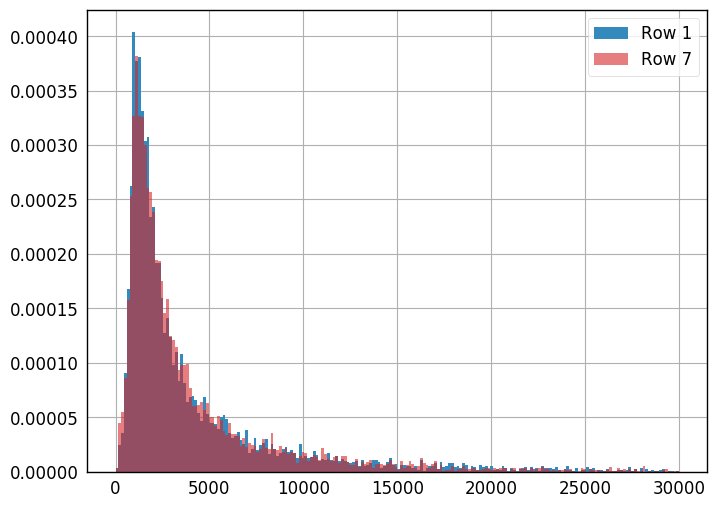

In [236]:
test = plt.hist(concatenate_energies(e2, np.where([row2==1])[1]), 200, range=(0,30000), normed=True,
                 label = "Row 1")
test2 = plt.hist(concatenate_energies(e2, np.where([row2==7])[1]),200, range=(0,30000),normed=True,
                 color="tab:red", alpha=0.6, label = "Row 7")

plt.legend(loc='best')

In [120]:
esm1 = test[1][np.argmax(test[0])]
esm2 = test2[1][np.argmax(test2[0])]

In [121]:
print(esm1)
print(esm2)

900.0
1050.0


In [9]:
t1_1, f1_1 = PPE_flux("../../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat")
t1_7, f1_7 = PPE_flux("../../datasets/PPE/ASD4_Counters_FOV1_ROW7.dat")

t2_1, f2_1 = PPE_flux("../../datasets/PPE/ASD4_Counters_FOV2_ROW1.dat")
t2_7, f2_7 = PPE_flux("../../datasets/PPE/ASD4_Counters_FOV2_ROW7.dat")

t1_1 = t1_1 / (1e9*3600*6)
t1_7 = t1_7 / (1e9*3600*6)
t2_1 = t2_1 / (1e9*3600*6)
t2_7 = t2_7 / (1e9*3600*6)

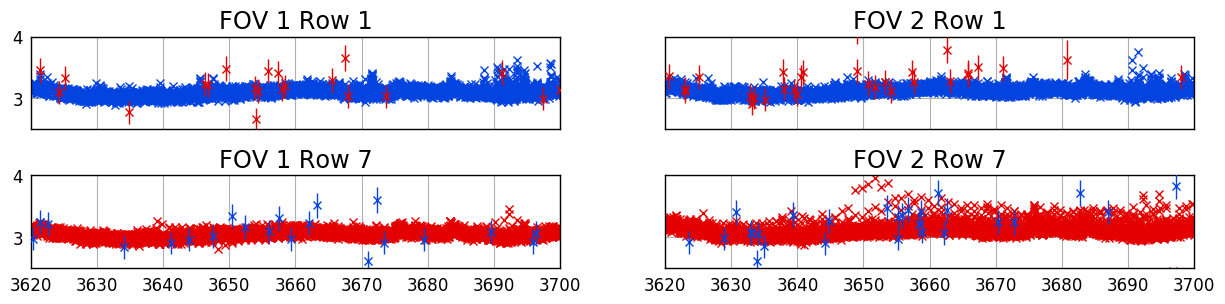

In [142]:
fig, axes = plt.subplots(2,2,sharey=True, sharex=True)

axes[0,0].plot(t1_1, f1_1, linestyle='', marker='x', color='xkcd:blue')
axes[0,0].errorbar(t1[row1==1]/3600/6/1e9, f1[row1==1], linestyle='', marker='x', color='xkcd:red',
                  yerr=err1[row1==1],zorder=20)

axes[1,0].plot(t1_7, f1_7, linestyle='', marker='x', color='xkcd:red')
axes[1,0].errorbar(t1[row1==7]/3600/6/1e9, f1[row1==7], linestyle='', marker='x', color='xkcd:blue',
                  yerr=err1[row1==7],zorder=20)

axes[0,1].plot(t2_1, f2_1, linestyle='', marker='x', color='xkcd:blue')
axes[0,1].errorbar(t2[row2==1]/3600/6/1e9, f2[row2==1], linestyle='', marker='x', color='xkcd:red',
                  yerr=err2[row2==1],zorder=20)

axes[1,1].plot(t2_7, f2_7, linestyle='', marker='x', color='xkcd:red')
axes[1,1].errorbar(t2[row2==7]/3600/6/1e9, f2[row2==7], linestyle='', marker='x', color='xkcd:blue', 
                   yerr=err2[row2==7],zorder=20)


for ifov in [0,1]:
    for irow in [0,1]:
        axes[irow, ifov].set_title("FOV {} Row {}".format(ifov+1, irow*6+1))
        
        
plt.xlim(3620,3700)
#plt.xlim(4340,4380)
plt.ylim(2.5,4)


plt.gcf().set_size_inches(15,3)

Good periods (OBMT-REV):

- 940 - 980    - Jun 20 to 30 2014
- 3120 - 3160  - Second Half of Dec 2015
- 3620 - 3700  - April 20 to May 10 2016
- 4340 - 4380  - second half of October 2016
- 5100 - 5250  - this seems to be the most extreme, around May 2017, but we have no observations there (2 per fov)

(basically, any longer uninterrupted period without flares)

-> Can't see I see anything

# Second: Compare the energy distros of BAM-SIF and SM-SIF

In [191]:
ts1,es1,rs1 = fits_energies_edgeless('../sm_sif/output/SM1_2016-06.fits')
ts2,es2,rs2 = fits_energies_edgeless('../sm_sif/output/SM2_2016-06.fits')
tb1, eb1, rb1 = fits_energies_edgeless('../bam_sif/output/BAM-SIF1_2016.fits')
tb2, eb2, rb2 = fits_energies_edgeless('../bam_sif/output/BAM-SIF2_2016.fits')
#tbobs, ebobs, rbobs = fits_energies_edgeless('../bam/output/2017-07-03/BAM-OBS1_OBMT_START_115987587366952704.fits')

In [192]:
es = concatenate_energies(es1, range(len(es1))) + concatenate_energies(es2, range(len(es2)))
eb = concatenate_energies(np.array(eb1), range(len(eb1))) + concatenate_energies(eb2, range(len(eb2)))
#ebobs_conc = concatenate_energies(np.array(ebobs), range(len(ebobs)))

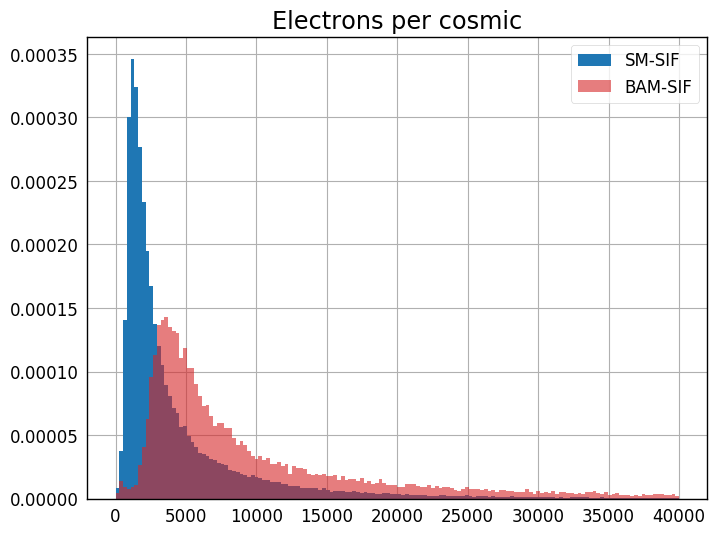

In [235]:
hist_sm = plt.hist(es, 150, range=(0,40000), normed=True, label="SM-SIF",
                  color="tab:blue", alpha=1)
hist_bam_sif = plt.hist(eb,150, range=(0,40000),normed=True, label='BAM-SIF',
                 color="tab:red", alpha=0.6)

plt.legend(loc='best')
plt.title("Electrons per cosmic")

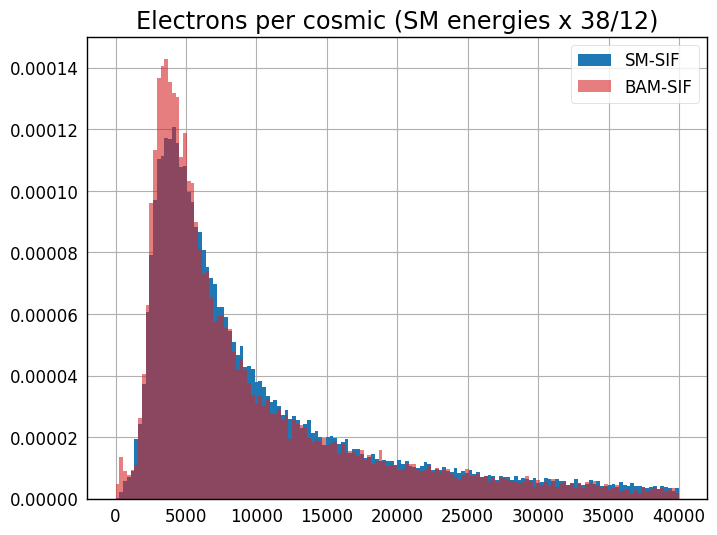

In [233]:
hist_sm = plt.hist(np.array(es)*38/12, 150, range=(0,40000), normed=True, label="SM-SIF",
                  color="tab:blue", alpha=1)
hist_bam_sif = plt.hist(eb,150, range=(0,40000),normed=True, label='BAM-SIF',
                 color="tab:red", alpha=0.6)

plt.legend(loc='best')
plt.title("Electrons per cosmic (SM energies x 38/12)")

-> Differences can be mostly explained by the different thicknesses, although I do pick up more around the maximum in BAM-SIF.

Could this be a signal/noise problem? These weak cosmics are, after all, weaker in SM due to the chip thickness, so they may be more easily overlooked.